# CISC451/893 Competition 1

**TEAM:**<br>
Ryan Elliott - 05999293<br>
Sizhe Guan 20090459<br>
Vishal Chotara 20307118
## Question 4<br>
### Interesting features of Kingston Transit Network
Planning bus routes for a city the size of Kingston can be challenging. The network must balance the low urban density with ease of access as well as creating a system that can has a degree of finanical sustainability. The system in its current deployment prioritizes stop distribution within the urban city rather than high network connectivity. To determine how connected the transit system is, a "transfer" feature was defined. We chose to define this feature as the number of bus routes within 200m of a bus stop.

In [26]:
!!pip install -r requirements.txt

['Requirement already satisfied: geopandas in /root/venv/lib/python3.7/site-packages (from -r requirements.txt (line 1)) (0.10.2)',
 'Requirement already satisfied: pandas in /shared-libs/python3.7/py/lib/python3.7/site-packages (from -r requirements.txt (line 2)) (1.2.5)',
 'Requirement already satisfied: numpy in /shared-libs/python3.7/py/lib/python3.7/site-packages (from -r requirements.txt (line 3)) (1.19.5)',
 'Requirement already satisfied: openpyxl in /root/venv/lib/python3.7/site-packages (from -r requirements.txt (line 4)) (3.0.9)',
 'Requirement already satisfied: xlrd in /root/venv/lib/python3.7/site-packages (from -r requirements.txt (line 5)) (2.0.1)',
 'Requirement already satisfied: geopy in /root/venv/lib/python3.7/site-packages (from -r requirements.txt (line 6)) (2.2.0)',
 'ERROR: Could not find a version that satisfies the requirement json (from -r requirements.txt (line 7)) (from versions: none)',
 'ERROR: No matching distribution found for json (from -r requirement

In [23]:
# The data environment is prepared in this cell. City of Kingston data is fetched
# using the API

import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
stop_api_url = "https://opendatakingston.cityofkingston.ca/api/records/1.0/search/?dataset=transit-gtfs-stops&q=&rows=799"
driveway_api_url = "https://opendatakingston.cityofkingston.ca/api/records/1.0/search/?dataset=driveways&q=&rows=-1&facet=material"
busroute_api_url = 'https://opendatakingston.cityofkingston.ca/api/records/1.0/search/?dataset=transit-gtfs-routes&q=&rows=-1&facet=route_short_name&exclude.route_long_name=999+Maintenance+-+Out+of+Service'
stop_response = requests.get(stop_api_url)
driveway_response = requests.get(driveway_api_url)
busroute_response = requests.get(busroute_api_url)

In [ ]:
# Data must be unpacked using json() method.
x = stop_response.json()
x_driveway = driveway_response.json()
x_busroute = busroute_response.json()

# The json() frames are then turned into Pandas dataframes.
transit_stops = pd.json_normalize(x,'records')
driveways = pd.json_normalize(x_driveway,'records')
busroute = pd.json_normalize(x_busroute,'records')

The city actively maintains and updates the opendata the databases. Sometimes the new records do not have GPS coordinates. The records without GPS coordinates are removed from analysis.

In [ ]:
# drops data if there is no GPS coordinates.
driveways = driveways.dropna(subset = ['fields.geo_point_2d'],how = 'all')

GPS coordinates are points on a sphere. Measuring the distance between poinst cannot be completed in cartesian space. The points must be projected onto a sphere to measure the arc length between the points. The haversin function is a common approximation used to measure the poits between two GPS coordinates.

In [ ]:
import math

def haversine(coord1,coord2):
    # Takes two coordinate vectors coord1 and coord2 and 
    # returns the distance between two points in metres
    
    # Radius of the Earth at Kingston. 
    # Assuming mean elevation of 93m above sea level.
    R = 6367869
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a),math.sqrt(1-a))

In [ ]:
transit_stops['bus_routes'] = pd.Series()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


The next section of code is trying to determine which routes service which stops and can be used to determine which stops serve as potential transfers between bus routes. A stop is said to be part of a bus route if the haversine formula measures a distance of \<200m of the shaded route to the stop. The routes are stored in a list for that record in the data frame.

In [ ]:
# The calculation needs to be complete for all bus stops. Stops need to be recorded in the dataframe. TBD.
k = 0
for s in transit_stops['fields.stop_coordinates']:
    stop_test = np.array(s)
    route_list = list()
    for route, ind in enumerate(busroute['fields.shape.coordinates']):
        p = 0
        route_test = np.array(busroute['fields.shape.coordinates'][route][0])
        for ind in route_test:
            test_param = haversine(np.flip(route_test[p]),stop_test)
            if test_param<150:
                # Append bus route to list.
                route_list.append(busroute['fields.route_short_name'][route])
                # Loop breaks if stop identified as being within 100m of bus route.
                break


            p = p+1

    transit_stops['bus_routes'][k] = route_list
    # print(transit_stops['fields.stop_name'][k]," ",transit_stops['bus_routes'][k])
    k = k+1



/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


The number of routes each stop services can be seen accross the network using a histogram. There are 38 stops which were not assigned to a route. This is likely due to the distcrete spacing of the GPS shape coordinates in the bus route feature. These can be binned with the stops that service a single route. What is pretty interesting is that there are 19 bus stops that have 10 bus routes within 200m of the stop.

In [ ]:
print(np.histogram(transit_stops['bus_routes'].str.len()))

(array([ 38, 461, 113, 109,  22,  17,   7,   4,   9,  19]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))


In [ ]:
print(np.histogram(transit_stops['bus_routes'].str.len(),bins=[0,2,3,4,5,6,7,8,9,10]))

(array([499, 113, 109,  22,  17,   7,   4,   9,  19]), array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10]))


In [ ]:
print(round(100*499/799),'% of the transit network does not have a transfer.')

62 % of the transit network does not have a transfer.


### Analyzing October 2017 Transit Data

Riding data from October 2017 provided to us by City of Kingston where each data point includes date/time, the type of boarding, bus and route number, and latitude/longitude where the boarding was recorded.  

We will be performing surface-level statistical analysis on the data to see if there is anything we can discover to improve the bus routes of Kingston.

In [10]:
transit_df = pd.read_excel('Transit Data - October.xlsx')
transit_df.head()

,Date,Time,Class,Operation,Bus,Route,Latitude,Longitude
0,2017-10-01,1900-01-01 01:43:03,QUEENS,Exact Fare,620,17,44.227860,-76.496938
1,2017-10-01,1900-01-01 01:43:08,QUEENS,Exact Fare,620,17,44.227860,-76.496938
2,2017-10-01,1900-01-01 01:58:13,ADULT,Pass (Multi-ride card),620,17,44.232035,-76.491397
3,2017-10-01,1900-01-01 01:58:25,QUEENS,Exact Fare,620,17,44.232035,-76.491397
4,2017-10-01,1900-01-01 01:58:27,QUEENS,Exact Fare,620,17,44.232035,-76.491397


In [11]:
print('Bus routes frequency: ')
transit_df['Route'].value_counts()

Bus routes frequency: 


701    96384
2      93880
501    78520
1      71450
502    71229
3      40953
601    38617
4      31207
7      24508
15     24001
12     23567
6      20116
11     19183
16     17555
20     16939
18     12349
10     11683
14      4777
13      3616
8       2295
17      1710
Name: Route, dtype: int64

We can see that a lot of people take the 701 and 2 the most compared to 14,13,8 and 17 which are taken the least. We can choose to ignore results for 8 and 13 as they only operate during hours of peak demand. 

Next we will look at routes used by adults and students in Kingston as Kingston has 2 large post-secondary schools.

In [12]:
group_df = transit_df.groupby(['Class', 'Route']).size()

In [13]:
# QUEENS Students
print('Top 5 routes used by QUEENS group:')
print(group_df['QUEENS'].sort_values(ascending=False).head())
print('\n5 least used routes by QUEENS group:')
print(group_df['QUEENS'].sort_values().head())

Top 5 routes used by QUEENS group:
Route
2      40960
1      32019
701    25570
501    23531
502    21594
dtype: int64

5 least used routes by QUEENS group:
Route
10     213
14     257
11     803
16    1013
15    1134
dtype: int64


In [14]:
# ADULTS
print('Top 5 routes used by ADULT group:')
print(group_df['ADULT'].sort_values(ascending=False).head())
print('\n5 least used routes by ADULT group:')
print(group_df['ADULT'].sort_values().head())

Top 5 routes used by ADULT group:
Route
701    30638
2      21921
501    20533
502    18949
1      18932
dtype: int64

5 least used routes by ADULT group:
Route
17      73
8      230
20     251
13     520
14    1375
dtype: int64


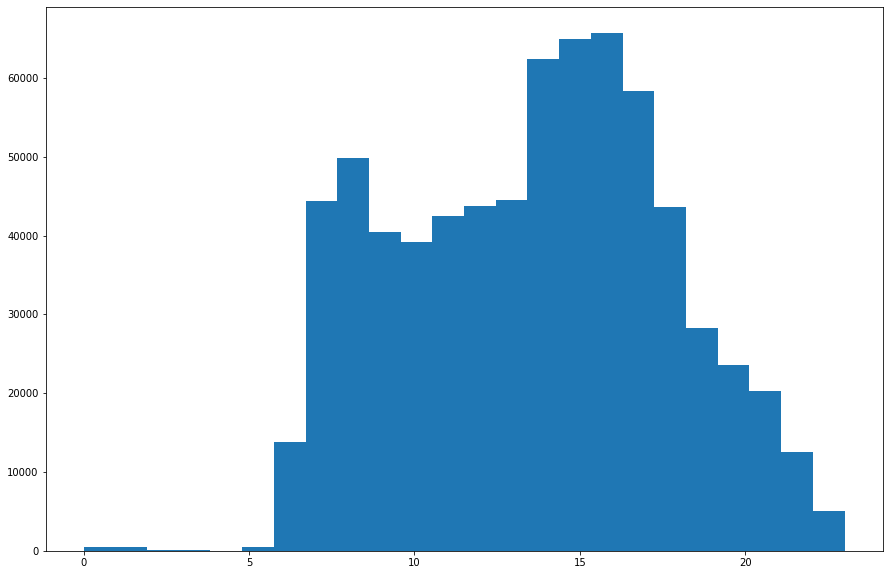

In [25]:
# cleaning time data and then plotting a histogram to show most active times
plt.figure(figsize=(15,10))
plt.hist(transit_df['Time'].dt.hour, bins=24)
plt.show()

From the histogram we can see that the most busy time from the pubilc is around 3:00 PM and then there is a sharp decrease in passengers.

We can see that the top 5 routes used between both groups are the same, only varying in the number of uses. The varying may be due to Queens students using non express buses to get to different parts of campus. This data certainly would allow Kingston to adjust their bus routes to add or remove bus routes based on the frequency of uses, the most busy times, and relate to specific areas of Kingston and see how routes can be planned to provide more service to those specific areas. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ba3a38b4-573b-4649-8117-71de8550c212' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>